<a href="https://colab.research.google.com/github/surajpandey11/capstone-project-3--news-prediction/blob/main/Copy_of_News_Popularity_Prediction_in_Social_Media_Capstone_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# <b><u> Project Title : Predicting the news popularity in multiple social media platforms. </u></b>

## <b> Problem Description </b>

### This is a large data set of news items and their respective social feedback on multiple platforms: Facebook, Google+ and LinkedIn.The collected data relates to a period of 8 months, between November 2015 and July 2016, accounting for about 100,000 news items on four different topics: Economy, Microsoft, Obama and Palestine.


## <b> Data Description </b>

### <b>Attribute Information: </b>

* ### IDLink (numeric): Unique identifier of news items
* ### Title (string): Title of the news item according to the official media sources
* ### Headline (string): Headline of the news item according to the official media sources
* ### Source (string): Original news outlet that published the news item
* ### Topic (string): Query topic used to obtain the items in the official media sources
* ### PublishDate (timestamp): Date and time of the news items' publication
* ### SentimentTitle (numeric): Sentiment score of the text in the news items' title
* ### SentimentHeadline (numeric): Sentiment score of the text in the news items' headline
* ### Facebook (numeric): Final value of the news items' popularity according to the social media source Facebook
* ### GooglePlus (numeric): Final value of the news items' popularity according to the social media source Google+
* ### LinkedIn (numeric): Final value of the news items' popularity according to the social media source LinkedIn


### VARIABLES OF SOCIAL FEEDBACK DATA

* ### IDLink (numeric): Unique identifier of news items
* ### TS1 (numeric): Level of popularity in time slice 1 (0-20 minutes upon publication)
* ### TS2 (numeric): Level of popularity in time slice 2 (20-40 minutes upon publication)
* ### TS... (numeric): Level of popularity in time slice ...
* ### TS144 (numeric): Final level of popularity after 2 days upon publication

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import re
from xgboost import XGBRegressor
import xgboost as xgb
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.model_selection import GridSearchCV
from sklearn.naive_bayes import MultinomialNB
import seaborn as sns
from sklearn.multioutput import MultiOutputRegressor
from sklearn.ensemble import RandomForestRegressor
from spacy.lang.en import English
from spacy.lang.en.stop_words import stopword
from sklearn.base import TransformerMixin
from sklearn.feature_extraction.text import TfidfVectorizer 
from sklearn.feature_extraction.text import TfidfTransformer

import string
punctuations = string.punctuation
from sklearn.feature_extraction.text import HashingVectorizer

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
news=pd.read_csv('/content/drive/MyDrive/AlmaBetter/Module 4/Week 2/Day 1/Copy of News_Final.csv')

In [4]:
news.head()


,IDLink,Title,Headline,Source,Topic,PublishDate,SentimentTitle,SentimentHeadline,Facebook,GooglePlus,LinkedIn
0,99248.0,Obama Lays Wreath at Arlington National Cemetery,Obama Lays Wreath at Arlington National Cemete...,USA TODAY,obama,2002-04-02 00:00:00,0.000000,-0.053300,-1,-1,-1
1,10423.0,A Look at the Health of the Chinese Economy,"Tim Haywood, investment director business-unit...",Bloomberg,economy,2008-09-20 00:00:00,0.208333,-0.156386,-1,-1,-1
2,18828.0,Nouriel Roubini: Global Economy Not Back to 2008,"Nouriel Roubini, NYU professor and chairman at...",Bloomberg,economy,2012-01-28 00:00:00,-0.425210,0.139754,-1,-1,-1
3,27788.0,Finland GDP Expands In Q4,Finland's economy expanded marginally in the t...,RTT News,economy,2015-03-01 00:06:00,0.000000,0.026064,-1,-1,-1
4,27789.0,"Tourism, govt spending buoys Thai economy in J...",Tourism and public spending continued to boost...,The Nation - Thailand&#39;s English news,economy,2015-03-01 00:11:00,0.000000,0.141084,-1,-1,-1


In [5]:
news=news.iloc[:40000,:]

In [6]:
news.shape


(40000, 11)

In [7]:
news.Headline[0]

'Obama Lays Wreath at Arlington National Cemetery. President Barack Obama has laid a wreath at the Tomb of the Unknowns to honor'

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


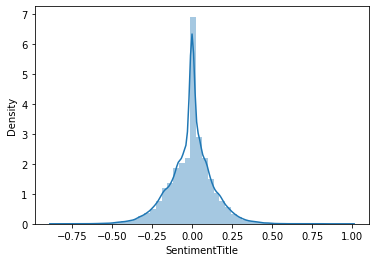

In [8]:
sns.distplot(news['SentimentTitle'])

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


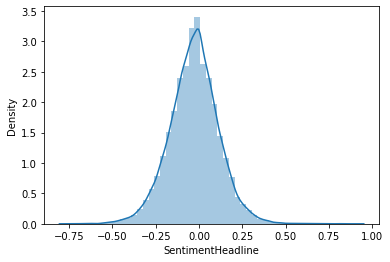

In [9]:
sns.distplot(news['SentimentHeadline'])

In [10]:
news.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   IDLink             40000 non-null  float64
 1   Title              40000 non-null  object 
 2   Headline           39996 non-null  object 
 3   Source             39883 non-null  object 
 4   Topic              40000 non-null  object 
 5   PublishDate        40000 non-null  object 
 6   SentimentTitle     40000 non-null  float64
 7   SentimentHeadline  40000 non-null  float64
 8   Facebook           40000 non-null  int64  
 9   GooglePlus         40000 non-null  int64  
 10  LinkedIn           40000 non-null  int64  
dtypes: float64(3), int64(3), object(5)
memory usage: 3.4+ MB


In [11]:
news.Title[0]

'Obama Lays Wreath at Arlington National Cemetery'

In [12]:
news.Facebook.value_counts()

 0        7952
 1        3007
-1        2803
 2        2231
 3        1587
          ... 
 1073        1
 1201        1
 3280        1
 15606       1
 3790        1
Name: Facebook, Length: 1934, dtype: int64

In [13]:
news.GooglePlus.value_counts()

 0      21518
 1       4500
-1       2743
 2       2318
 3       1447
        ...  
 371        1
 137        1
 243        1
 211        1
 176        1
Name: GooglePlus, Length: 258, dtype: int64

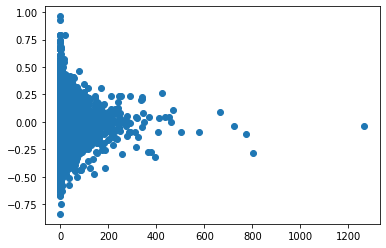

In [14]:
plt.scatter(x=news['GooglePlus'],y=news['SentimentTitle'])

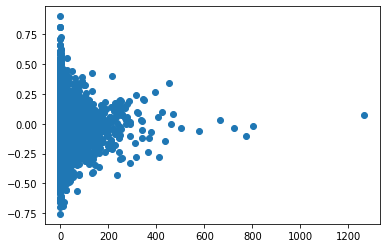

In [15]:
plt.scatter(x=news['GooglePlus'],y=news['SentimentHeadline'])

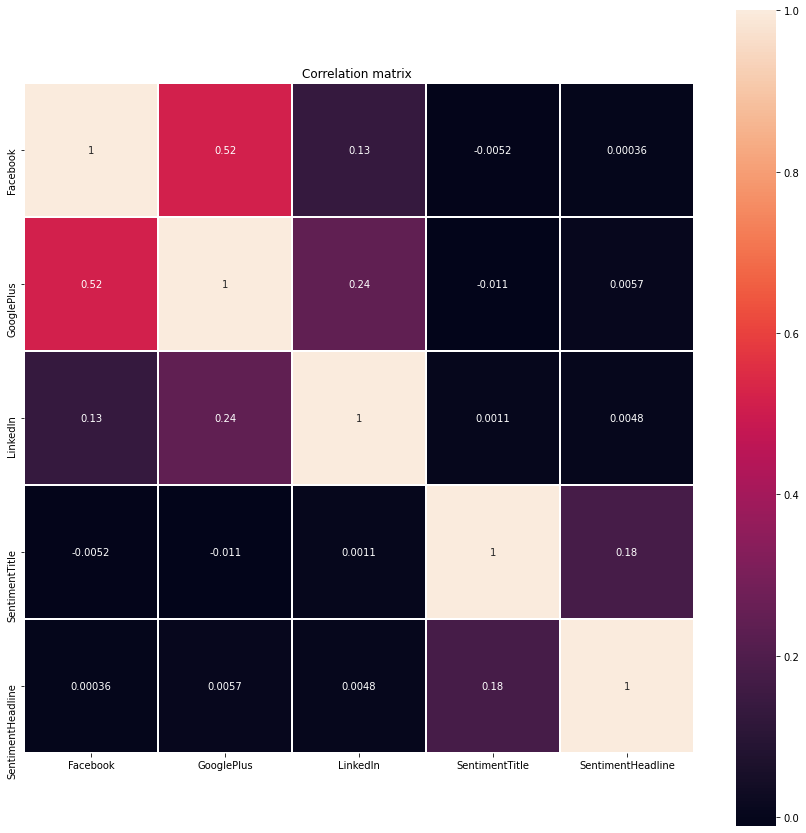

In [16]:
plt.figure(figsize=(15,15))
_ = sns.heatmap(news[['Facebook','GooglePlus','LinkedIn','SentimentTitle','SentimentHeadline']].corr(), square=True,linewidths=0.5,linecolor='w',annot=True)
plt.title('Correlation matrix ')

plt.show()

In [17]:
missing_val = pd.DataFrame(news.isnull().sum())

missing_val = missing_val.reset_index()
missing_val

,index,0
0,IDLink,0
1,Title,0
2,Headline,4
3,Source,117
4,Topic,0
5,PublishDate,0
6,SentimentTitle,0
7,SentimentHeadline,0
8,Facebook,0
9,GooglePlus,0


In [18]:
news['Source'].value_counts()

Bloomberg             715
Reuters               550
ABC News              454
Business Insider      435
New York Times        410
                     ... 
The Gateway Online      1
Daily Californian       1
The Temple News         1
The Art of Gears        1
KVUE                    1
Name: Source, Length: 4064, dtype: int64

In [19]:
news['Topic'].value_counts()

economy      14827
obama        11846
microsoft     9339
palestine     3988
Name: Topic, dtype: int64

In [20]:
from spacy.lang.en import English
from spacy.lang.en.stop_words import STOP_WORDS

In [21]:
news.dropna(inplace=True)

In [22]:
cols = ['Title', 'Headline']
news['combined'] = news[cols].apply(lambda row: '_'.join(row.values.astype(str)), axis=1)

In [23]:
news

,IDLink,Title,Headline,Source,Topic,PublishDate,SentimentTitle,SentimentHeadline,Facebook,GooglePlus,LinkedIn,combined
0,99248.0,Obama Lays Wreath at Arlington National Cemetery,Obama Lays Wreath at Arlington National Cemete...,USA TODAY,obama,2002-04-02 00:00:00,0.000000,-0.053300,-1,-1,-1,Obama Lays Wreath at Arlington National Cemete...
1,10423.0,A Look at the Health of the Chinese Economy,"Tim Haywood, investment director business-unit...",Bloomberg,economy,2008-09-20 00:00:00,0.208333,-0.156386,-1,-1,-1,A Look at the Health of the Chinese Economy_Ti...
2,18828.0,Nouriel Roubini: Global Economy Not Back to 2008,"Nouriel Roubini, NYU professor and chairman at...",Bloomberg,economy,2012-01-28 00:00:00,-0.425210,0.139754,-1,-1,-1,Nouriel Roubini: Global Economy Not Back to 20...
3,27788.0,Finland GDP Expands In Q4,Finland's economy expanded marginally in the t...,RTT News,economy,2015-03-01 00:06:00,0.000000,0.026064,-1,-1,-1,Finland GDP Expands In Q4_Finland's economy ex...
4,27789.0,"Tourism, govt spending buoys Thai economy in J...",Tourism and public spending continued to boost...,The Nation - Thailand&#39;s English news,economy,2015-03-01 00:11:00,0.000000,0.141084,-1,-1,-1,"Tourism, govt spending buoys Thai economy in J..."
...,...,...,...,...,...,...,...,...,...,...,...,...
39995,78868.0,Obama: No Excuse For GOP Not To Vote On A Cour...,President Barack Obama declared Tuesday that R...,CBS San Francisco,obama,2016-02-16 16:41:00,0.204478,0.067798,-1,-1,-1,Obama: No Excuse For GOP Not To Vote On A Cour...
39996,24947.0,"Microsoft Patents a Modular PC, Get Netflix Pa...","Microsoft wants you to build modular PCs, Netf...",MakeUseOf,microsoft,2016-02-16 16:41:31,-0.105673,-0.066734,8,4,1,"Microsoft Patents a Modular PC, Get Netflix Pa..."
39997,78366.0,Obama Urges Senate To Act On Court Nominee Des...,President Barack Obama on Tuesday vowed to pic...,Malaysian Digest,obama,2016-02-16 16:42:00,-0.188445,0.046875,0,0,0,Obama Urges Senate To Act On Court Nominee Des...
39998,78899.0,Obama calls for ‘tangible steps’ to lower Sout...,RANCHO MIRAGE: President Barack Obama on Tuesd...,Free Malaysia Today,obama,2016-02-16 16:45:00,0.094222,0.151598,-1,-1,-1,Obama calls for ‘tangible steps’ to lower Sout...


In [24]:
news.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 39879 entries, 0 to 39999
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   IDLink             39879 non-null  float64
 1   Title              39879 non-null  object 
 2   Headline           39879 non-null  object 
 3   Source             39879 non-null  object 
 4   Topic              39879 non-null  object 
 5   PublishDate        39879 non-null  object 
 6   SentimentTitle     39879 non-null  float64
 7   SentimentHeadline  39879 non-null  float64
 8   Facebook           39879 non-null  int64  
 9   GooglePlus         39879 non-null  int64  
 10  LinkedIn           39879 non-null  int64  
 11  combined           39879 non-null  object 
dtypes: float64(3), int64(3), object(6)
memory usage: 4.0+ MB


In [25]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [26]:
import string
from nltk.corpus import stopwords

In [27]:
stopwords.words('english')

['i',
 'me',
 'my',
 'myself',
 'we',
 'our',
 'ours',
 'ourselves',
 'you',
 "you're",
 "you've",
 "you'll",
 "you'd",
 'your',
 'yours',
 'yourself',
 'yourselves',
 'he',
 'him',
 'his',
 'himself',
 'she',
 "she's",
 'her',
 'hers',
 'herself',
 'it',
 "it's",
 'its',
 'itself',
 'they',
 'them',
 'their',
 'theirs',
 'themselves',
 'what',
 'which',
 'who',
 'whom',
 'this',
 'that',
 "that'll",
 'these',
 'those',
 'am',
 'is',
 'are',
 'was',
 'were',
 'be',
 'been',
 'being',
 'have',
 'has',
 'had',
 'having',
 'do',
 'does',
 'did',
 'doing',
 'a',
 'an',
 'the',
 'and',
 'but',
 'if',
 'or',
 'because',
 'as',
 'until',
 'while',
 'of',
 'at',
 'by',
 'for',
 'with',
 'about',
 'against',
 'between',
 'into',
 'through',
 'during',
 'before',
 'after',
 'above',
 'below',
 'to',
 'from',
 'up',
 'down',
 'in',
 'out',
 'on',
 'off',
 'over',
 'under',
 'again',
 'further',
 'then',
 'once',
 'here',
 'there',
 'when',
 'where',
 'why',
 'how',
 'all',
 'any',
 'both',
 'each

In [28]:
[punc for punc in string.punctuation]

['!',
 '"',
 '#',
 '$',
 '%',
 '&',
 "'",
 '(',
 ')',
 '*',
 '+',
 ',',
 '-',
 '.',
 '/',
 ':',
 ';',
 '<',
 '=',
 '>',
 '?',
 '@',
 '[',
 '\\',
 ']',
 '^',
 '_',
 '`',
 '{',
 '|',
 '}',
 '~']

In [29]:
def text_process(msg):
    nopunc =[char for char in msg if char not in string.punctuation]
    nopunc=''.join(nopunc)
    return ' '.join([word for word in nopunc.split() if word.lower() not in stopwords.words('english')])

In [30]:
news['tokenized_message'] = news['combined'].apply(text_process)

In [31]:
news

,IDLink,Title,Headline,Source,Topic,PublishDate,SentimentTitle,SentimentHeadline,Facebook,GooglePlus,LinkedIn,combined,tokenized_message
0,99248.0,Obama Lays Wreath at Arlington National Cemetery,Obama Lays Wreath at Arlington National Cemete...,USA TODAY,obama,2002-04-02 00:00:00,0.000000,-0.053300,-1,-1,-1,Obama Lays Wreath at Arlington National Cemete...,Obama Lays Wreath Arlington National CemeteryO...
1,10423.0,A Look at the Health of the Chinese Economy,"Tim Haywood, investment director business-unit...",Bloomberg,economy,2008-09-20 00:00:00,0.208333,-0.156386,-1,-1,-1,A Look at the Health of the Chinese Economy_Ti...,Look Health Chinese EconomyTim Haywood investm...
2,18828.0,Nouriel Roubini: Global Economy Not Back to 2008,"Nouriel Roubini, NYU professor and chairman at...",Bloomberg,economy,2012-01-28 00:00:00,-0.425210,0.139754,-1,-1,-1,Nouriel Roubini: Global Economy Not Back to 20...,Nouriel Roubini Global Economy Back 2008Nourie...
3,27788.0,Finland GDP Expands In Q4,Finland's economy expanded marginally in the t...,RTT News,economy,2015-03-01 00:06:00,0.000000,0.026064,-1,-1,-1,Finland GDP Expands In Q4_Finland's economy ex...,Finland GDP Expands Q4Finlands economy expande...
4,27789.0,"Tourism, govt spending buoys Thai economy in J...",Tourism and public spending continued to boost...,The Nation - Thailand&#39;s English news,economy,2015-03-01 00:11:00,0.000000,0.141084,-1,-1,-1,"Tourism, govt spending buoys Thai economy in J...",Tourism govt spending buoys Thai economy Janua...
...,...,...,...,...,...,...,...,...,...,...,...,...,...
39995,78868.0,Obama: No Excuse For GOP Not To Vote On A Cour...,President Barack Obama declared Tuesday that R...,CBS San Francisco,obama,2016-02-16 16:41:00,0.204478,0.067798,-1,-1,-1,Obama: No Excuse For GOP Not To Vote On A Cour...,Obama Excuse GOP Vote Court NomineePresident B...
39996,24947.0,"Microsoft Patents a Modular PC, Get Netflix Pa...","Microsoft wants you to build modular PCs, Netf...",MakeUseOf,microsoft,2016-02-16 16:41:31,-0.105673,-0.066734,8,4,1,"Microsoft Patents a Modular PC, Get Netflix Pa...",Microsoft Patents Modular PC Get Netflix Passw...
39997,78366.0,Obama Urges Senate To Act On Court Nominee Des...,President Barack Obama on Tuesday vowed to pic...,Malaysian Digest,obama,2016-02-16 16:42:00,-0.188445,0.046875,0,0,0,Obama Urges Senate To Act On Court Nominee Des...,Obama Urges Senate Act Court Nominee Despite W...
39998,78899.0,Obama calls for ‘tangible steps’ to lower Sout...,RANCHO MIRAGE: President Barack Obama on Tuesd...,Free Malaysia Today,obama,2016-02-16 16:45:00,0.094222,0.151598,-1,-1,-1,Obama calls for ‘tangible steps’ to lower Sout...,Obama calls ‘tangible steps’ lower South China...


In [32]:
# news['tokenized_message_headlines'] = news['Headline'].apply(text_process)

In [33]:
# news

In [34]:
 from sklearn.feature_extraction.text import TfidfVectorizer

In [35]:
vectorizer = TfidfVectorizer(min_df=5,max_df=.90)
X = vectorizer.fit_transform(news['tokenized_message'])

In [36]:
print(vectorizer.get_feature_names())

['000', '0000', '01', '02', '025', '03', '04', '05', '050', '06', '07', '078', '08', '09', '10', '100', '1000', '10000', '100000', '100meter', '100th', '101', '102', '103', '104', '105', '10586', '1058629', '106', '108', '10abarrel', '10based', '10microsoft', '10microsofts', '10nation', '10perbarrel', '10powered', '10s', '10th', '10the', '10year', '11', '110', '110000', '114', '116', '118', '11th', '11year', '12', '120', '121', '1211', '125', '127', '128', '129', '12nation', '12th', '12year', '13', '130', '131', '135', '138', '139', '13th', '13yearold', '14', '140', '14000', '14251', '1437', '145', '149', '14th', '15', '150', '1500', '150th', '151000', '1511', '151k', '156', '15gb', '15th', '15year', '15yearold', '16', '160', '1620', '16th', '16yearold', '17', '170', '1718', '1718new', '175', '17brazils', '17day', '17yearold', '18', '180', '183', '185', '18b', '18bn', '18th', '18yearold', '19', '190', '1947', '1948', '195', '196', '1961', '1963', '1967', '1970', '1975', '1980s', '1985'

In [37]:
len(vectorizer.get_feature_names())

13592

In [38]:
# X.toarray().shape

In [39]:
# vectorizer1 = TfidfVectorizer(min_df=10,max_df=0.90)
# Y = vectorizer1.fit_transform(news['tokenized_message_headlines'])

In [40]:
print(vectorizer.get_feature_names())

['000', '0000', '01', '02', '025', '03', '04', '05', '050', '06', '07', '078', '08', '09', '10', '100', '1000', '10000', '100000', '100meter', '100th', '101', '102', '103', '104', '105', '10586', '1058629', '106', '108', '10abarrel', '10based', '10microsoft', '10microsofts', '10nation', '10perbarrel', '10powered', '10s', '10th', '10the', '10year', '11', '110', '110000', '114', '116', '118', '11th', '11year', '12', '120', '121', '1211', '125', '127', '128', '129', '12nation', '12th', '12year', '13', '130', '131', '135', '138', '139', '13th', '13yearold', '14', '140', '14000', '14251', '1437', '145', '149', '14th', '15', '150', '1500', '150th', '151000', '1511', '151k', '156', '15gb', '15th', '15year', '15yearold', '16', '160', '1620', '16th', '16yearold', '17', '170', '1718', '1718new', '175', '17brazils', '17day', '17yearold', '18', '180', '183', '185', '18b', '18bn', '18th', '18yearold', '19', '190', '1947', '1948', '195', '196', '1961', '1963', '1967', '1970', '1975', '1980s', '1985'

In [41]:
len(vectorizer1.get_feature_names())

NameError: ignored

In [ ]:
# sample = news[['Title','Headline']]
# sample = news.apply(lambda col: col.str.strip())

In [ ]:
# import scipy.sparse as sp
# vect = TfidfVectorizer(min_df=5,max_df=0.90)
# train = sp.hstack(sample.apply(lambda col: vect.fit_transform(col)))

In [ ]:
facebook_obama=pd.read_csv('/content/drive/MyDrive/AlmaBetter/Module 4/Week 2/Day 1/Copy of Facebook_Obama.csv')

In [ ]:
facebook_obama

In [ ]:
plt.plot(facebook_obama.iloc[1,1:])

In [ ]:
news.Source.value_counts()

In [ ]:
from sklearn.model_selection import train_test_split
msg_train,msg_test,label_train,label_test = train_test_split(news['tokenized_message'],news['Facebook'],test_size=0.2)

In [ ]:
train_vectorized = vectorizer.transform(msg_train)
test_vectorized = vectorizer.transform(msg_test)

In [ ]:
train_array= train_vectorized.toarray()
test_array = test_vectorized.toarray()

In [ ]:
from sklearn.naive_bayes import GaussianNB
popularity_model = GaussianNB().fit(train_array,label_train)

In [ ]:
train_preds = popularity_model.predict(train_array)
test_preds = popularity_model.predict(test_array)

In [ ]:
def spacy_tokenizer(sentence):
    mytokens = nlp(sentence)

    mytokens = [ word.lemma_.lower().strip() if word.lemma_ != "-PRON-" else word.lower_ for word in mytokens ]

    mytokens = [ word for word in mytokens if word not in STOP_WORDS and word not in string.punctuation ]

    return ' '.join(mytokens)

In [43]:
X=news_df['Spacy_token']
Y=news_df['Facebook']

X_train,X_test,Y_train,Y_test=train_test_split(X,Y,test_size=0.2)

NameError: ignored

In [ ]:
vector=TfidfVectorizer(max_df = 0.9,min_df = 9)

In [ ]:
model=RandomForestRegressor(n_estimators=50,max_depth=None,random_state=0)
pipe_title = Pipeline([('vectorizer', vector),
                     ('regressor', model)])
pipe_title.fit(X_train,Y_train)

In [ ]:
test_pred_text=pipe_title.predict(X_test)

In [ ]:
print_metrics(Y_test,test_pred_text)

In [ ]:
X=news_df['token_text']
Y=news_df['LinkedIn']

In [ ]:

X_train,X_test,Y_train,Y_test=train_test_split(X,Y,test_size=0.2)

In [ ]:
model=LinearRegression()
pipe_title = Pipeline([('vectorizer', vector),
                     ('regressor', model)])
pipe_title.fit(X_train,Y_train)